In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Infos zum Datensatz

In [3]:
chunksize = 4_000_000
reader = pd.read_csv("data/2023_Yellow_Taxi_Trip_Data.csv", chunksize=chunksize)

# Den ersten Chunk holen
first_chunk = next(reader)

# Info anzeigen
print(first_chunk.info())


/tmp/ipykernel_1368/3725593021.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  first_chunk = next(reader)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(12), int64(4), object(3)
memory usage: 579.8+ MB
None


Wie wir sehen können ist der Datensatz recht gross und braucht viel Speicher, weshalb es sich nur in chunks bearbeiten lässt. 

Im Folgenden wird es vorallem darum gehen den Datensatz zu optimieren und wichtige Kennzahlen zu berechnen.

### Beschreiben des Datensatzes

In [4]:
second_chunk = next(reader)

print(second_chunk.describe())

/tmp/ipykernel_1368/2937111512.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  second_chunk = next(reader)


           VendorID  passenger_count  trip_distance    RatecodeID  \
count  4.000000e+06     3.923183e+06   4.000000e+06  3.923183e+06   
mean   1.727602e+00     1.360972e+00   3.781822e+00  1.542079e+00   
std    4.518873e-01     8.941351e-01   2.297640e+02  6.818267e+00   
min    1.000000e+00     0.000000e+00   0.000000e+00  1.000000e+00   
25%    1.000000e+00     1.000000e+00   1.050000e+00  1.000000e+00   
50%    2.000000e+00     1.000000e+00   1.780000e+00  1.000000e+00   
75%    2.000000e+00     1.000000e+00   3.310000e+00  1.000000e+00   
max    6.000000e+00     9.000000e+00   3.350043e+05  9.900000e+01   

       PULocationID  DOLocationID  payment_type   fare_amount         extra  \
count  4.000000e+06  4.000000e+06  4.000000e+06  4.000000e+06  4.000000e+06   
mean   1.657748e+02  1.641650e+02  1.194233e+00  1.851894e+01  1.581304e+00   
std    6.404286e+01  6.988149e+01  5.253597e-01  1.782087e+01  1.804177e+00   
min    1.000000e+00  1.000000e+00  0.000000e+00 -9.599000e+02 

In [5]:
df_header = pd.read_csv("data/2023_Yellow_Taxi_Trip_Data.csv", nrows=0)
print("Der Datensatz enthält folgende Informationen")
original_header = df_header.columns.tolist()
print("Spaltennamen:\n", original_header)
print("\nAnzahl Header: ", len(original_header))

with open("data/2023_Yellow_Taxi_Trip_Data.csv", "r", encoding="utf-8") as f:
    total_lines = sum(1 for _ in f) - 1

print(f"\nDie Datei hat ca. {total_lines:,} Zeilen.")

Der Datensatz enthält folgende Informationen
Spaltennamen:
 ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

Anzahl Header:  19

Die Datei hat ca. 38,310,226 Zeilen.


Um die Anzahl Zeilen zu erhalten konnte ich keine pandas einsetzen, da jedesmal das kernel kaputt gegangen ist. 
Unser Datensatz hat also um die 38 Millionen Zeilen/Taxifahrten im Jahr 2023 und zu einer Fahrt sind viel Daten vorhanden, wie zum Beispiel Preis, Uhrzeit und Distanz.

### Possible Data improvements

thanks to info and describe we can look at the whole data and are now able to say which columns are not useful for us. Those columns get deletet to safe RAM of our computers and reduce the data size.  
- VendorID: is 1, 2 or 6 because we won't be able to connect it to something useful we can delete it
- RatecodeID: the same thing as before, its 1 or 99 and in most cases 1 
- PULocationID & DOLocationID: they look interesting but we don't know which where is which location
- store_and_fwd_flag: always the same number and not clear what it mean
- mta_tax: always the same 0.5 (there are some errors)
- payment_type: not clear what is what

### Überprüfen der Spaltenlöschung

In [6]:
print("Datensatz nach Löschung:\n")
df = pd.read_csv("data/Taxi_Data_improved.csv", nrows=0)
print(f"Datensatz hat jetzt {df.shape[1]} Spalten")

Datensatz nach Löschung:

Datensatz hat jetzt 12 Spalten


### Wechsel zu Datetime

Aktuell liegt die Abfahrts und Ankunfts Zeit in der US-Datums form vor. Um die Zeiten für Rechnungen benutzen zu können, müssen wir die Zeitangaben in Datetime vorleigen haben. deshalb wurde das pythonscript change_to_datetime erstellt welches diese Angaben umwandelt

In [7]:
example_1 = pd.read_csv("data/2023_Yellow_Taxi_Trip_Data.csv", nrows=3)
print("Zeitangabe vor Änderung:\n")
print(example_1.iloc[:, 1:3])

example_2 = pd.read_csv("data/Taxi_final.csv", nrows=3)
print("\nZeitangabe nach Änderung:\n")
print(example_2.iloc[:, :2])

Zeitangabe vor Änderung:

     tpep_pickup_datetime   tpep_dropoff_datetime
0  01/01/2023 12:32:10 AM  01/01/2023 12:40:36 AM
1  01/01/2023 12:55:08 AM  01/01/2023 01:01:27 AM
2  01/01/2023 12:25:04 AM  01/01/2023 12:37:49 AM

Zeitangabe nach Änderung:

  tpep_pickup_datetime tpep_dropoff_datetime
0  2023-01-01 00:32:10   2023-01-01 00:40:36
1  2023-01-01 00:55:08   2023-01-01 01:01:27
2  2023-01-01 00:25:04   2023-01-01 00:37:49


### Erstellen eines repräsentativen Datensatzes

Unser Datensatz hat aktuell mehr als 38 Millionen Taxifahrten, es ist unmöglich (auch mit pandas) diesen in einem Stück einzulesen und zu analysieren, desshalb haben wir uns entschieden einen kleineren repräsentativen Datensatz zu erstellen. Zuerst wird das original chunkweise geshuffelt und anschliessen aus jedem gemischten chunk eine Prozentsatz an Daten random herausgenommen und in einem neuen Datensatz gespeichert. Der neue Datensatz sollte 6 Millionen Taxifahrten beinhalten.

In [10]:
print(f"Daten des originalen Datensatzes: {total_lines:,}")

with open("data/Taxi_sample_6M.csv", "r", encoding="utf-8") as f:
    new_total_lines = sum(1 for _ in f) - 1
print(f"Daten des neuen Datensatzes: {new_total_lines:,}")

Daten des originalen Datensatzes: 38,310,226
Daten des neuen Datensatzes: 6,000,002


### Wichtige Kennzahlen für Fahrzeit, Distanz und Gesamtpreis

(Mittelwert, Median, getrimmter Mittelwert, Modus, Quartile)

ValueError: boxplot method requires numerical columns, nothing to plot.

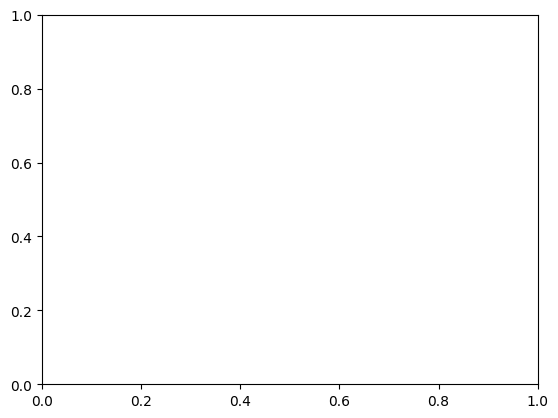

In [9]:
df.boxplot(column="trip_distance")
plt.title("Trip Distance Boxplot")
plt.show()

df.boxplot(column="trip_duration")
plt.title("Trip Duration Boxplot")
plt.show()


### Look for the outlier

In [ ]:
outliers = df[(df["trip_distance"] > 60000) | (df["trip_duration"] > 1500)]
outliers.index
df.loc[outliers.index]


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration
59232,2023-01-01 18:45:20,2023-01-03 14:01:32,1,3.19,2,38.7,0.0,0.0,0.0,1.0,41.45,0.0,2596.200000
59233,2023-01-01 18:45:20,2023-01-03 14:01:58,1,0.01,4,-3.0,-5.0,0.0,0.0,-1.0,-10.75,0.0,2596.633333
59234,2023-01-01 18:45:20,2023-01-03 14:01:58,1,0.01,4,3.0,5.0,0.0,0.0,1.0,10.75,0.0,2596.633333
62642,2023-01-01 19:40:43,2023-01-01 20:21:48,1,62359.52,2,0.0,0.0,0.0,0.0,0.0,2.50,2.5,41.083333


In [ ]:
outliers = df[(df["fare_amount"] < 0)]
outliers.index
df.loc[outliers.index]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_duration
133,2023-01-01 00:28:29,2023-01-01 00:31:03,1,0.42,4,-5.1,-1.0,0.0,0.00,-1.0,-10.1,-2.5,2.566667
264,2023-01-01 00:20:18,2023-01-01 00:27:56,2,1.19,4,-9.3,-1.0,0.0,0.00,-1.0,-14.3,-2.5,7.633333
324,2023-01-01 00:52:22,2023-01-01 01:14:03,1,4.89,4,-25.4,-1.0,0.0,0.00,-1.0,-30.4,-2.5,21.683333
620,2023-01-01 00:06:39,2023-01-01 00:10:02,1,0.52,2,-5.1,-1.0,0.0,0.00,-1.0,-10.1,-2.5,3.383333
923,2023-01-01 00:34:39,2023-01-01 00:40:25,2,0.85,4,-7.2,-1.0,0.0,0.00,-1.0,-12.2,-2.5,5.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254092,2023-01-04 13:31:44,2023-01-04 13:32:00,1,0.03,2,-3.0,0.0,0.0,0.00,-1.0,-7.0,-2.5,0.266667
254391,2023-01-04 13:27:27,2023-01-04 13:37:01,1,1.44,4,-11.4,0.0,0.0,0.00,-1.0,-15.4,-2.5,9.566667
254654,2023-01-04 13:50:24,2023-01-04 14:31:53,1,11.20,4,-70.0,0.0,0.0,-6.55,-1.0,-81.8,-2.5,41.483333
254702,2023-01-04 13:58:01,2023-01-04 14:02:36,1,0.64,4,-6.5,0.0,0.0,0.00,-1.0,-10.5,-2.5,4.583333
